# Introduction to Clustering with K-Means

> "If the intelligence is a cake the bulk of the cake is unsupervised learning, the icing on the cake is supervised learning and the cherry on the cake is reinforcement learning." Yann LeCun (NIPS 2016)

This notebook will showcase how to cluster data with the K-Means algorithm. We will use scikit-learn's implementation and apply it to the fashion MNIST dataset.


In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.utils import resample
from sklearn.metrics import rand_score

from tensorflow.keras.datasets import fashion_mnist

from yellowbrick.cluster import KElbowVisualizer

In [212]:
#Let's define some colors (yaaay corporate identity!)
NF_Nemo="#FF4A11"
NF_Granite="#252629"
NF_Foam="#FFFFFF"

NF_DarkNemo="#E5430F"
NF_LightNemo="#FFB7A0"
NF_Dark_Grey="#3F4145"

NF_Blue="#33A5FF"
NF_Green="#A7E521"
NF_Yellow="#FFE600"
NF_Purple="#696CFF"

## Notebook Objectives:

* short EDA (show data and label)
* elbow plot
* cluster sklearn kmeans 
* error analysis by showing pictures of clusters
* How do you figure out if clustering worked, if you don't have pictures that are easy to inspect?

Elbow with yellowbrick: dashed line is point of maximum curvature


## The Data

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset contains 70000 28x28 greyscale images of fashion products from a dataset of Zalando article images. It consists of 10 different classes which 7000 images per category. It is freely available for training and testing machine learning applications and can be directly downloaded from Tensorflow.

The dataset introduced by Zalando is a more contemporary version of the original MNIST dataset. 

In [2]:
# Download data from Tensorflow
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('Fashion MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('y_test:  '  + str(y_test.shape))


Fashion MNIST Dataset Shape:
X_train: (60000, 28, 28)
y_train: (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


As we can see, we have 60,000 samples in the training set (-> X_train) with a dimension of 28x28 each. Additionally, we got 10,000 samples for the testing set(-> X_test) with the same dimensions.

The Dataset was designed to be used for supervised learning, so we also get the correct labels (in this case class labels) for all of the samples in the training (-> Y_train) and test (-> Y_test) sets. Typically, clustering is used in unsupervised settings. Then, we wouldn't have the labels available. For the purpose of this meetup, however we will use them to evaluate how good our clustering is working.

The correct class names are encoded as numbers 0-9 but we can use the following dictionary to turn it into human readable labels.

In [214]:
# class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names_dict = dict(zip(range(10),class_names)) 
#Here, its not really necessary to turn the class names into a dictionary,
#However, I still like to to it as dictionaries are more robust against changing the sequence unintentionally.

display(class_names_dict)


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

So, as we can see we get some different items that most of us have in their wardrobes. Bet let's have a closer look at the data that we have:

In [215]:
print(f'This is the first item: \n\n {X_train[0]} \n\n It has the dimension: {X_train[0].shape}. \n It has the label {Y_train[0]} assigned, which means it is a {class_names_dict[Y_train[0]]}')

This is the first item: 

 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0

Can you recognise the boot from that numbers? Me neither. We know it is supposed to be a picture, so lets treat it like a picture instead. The numbers in the data (0 to 255) represent the color of each of the 28x28 pixels we have. So lets use matplotlibs [plt.imshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) for a better presentation - we just add some custom labels, colors etc. to improve the visualization:

In [216]:
def custom_imshow(image,ax,title,show_minor=False,show_major=False):
    # Show image
    im = ax.imshow(image,
                    interpolation='none', 
                    vmin=0, 
                    vmax=255, 
                    aspect='equal')
    
    # Add title
    ax.set_title(title)

    # Add Major ticks
    ax.set_xticks(np.arange(0, 28, 7))
    ax.set_yticks(np.arange(0, 28, 7))

    # Add Labels for major ticks
    ax.set_xticklabels(np.arange(0, 28, 7))
    ax.set_yticklabels(np.arange(0, 28, 7))

    # Add Minor ticks (for the minor grid)
    ax.set_xticks(np.arange(-.5, 28, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 28, 1), minor=True)
    
    # Remove Minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)
    
    # Add (or don't) the selected grid lines
    if(show_minor):
        ax.grid(which='minor', color=NF_Blue, linestyle='-', linewidth=1)
    else:
        ax.grid(which='minor',visible=False)
    if(show_major):
        ax.grid(which='major', color=NF_Nemo, linestyle='-', linewidth=1)
    else:
        ax.grid(which='major',visible=False)
    


    

And now we get a proper visualisation of our sample:

This is the first item:


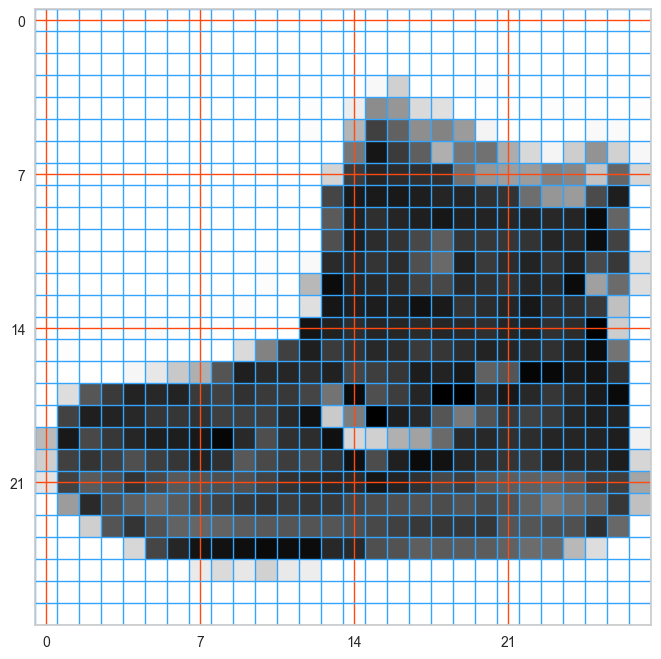

It has the dimension: (28, 28). 
It has the label 9 assigned, which means it is a Ankle boot.


In [217]:
print(f'This is the first item:')
plt.figure(figsize=(8,8))
ax=plt.gca()
custom_imshow(X_train[0],ax,title="",show_minor=True,show_major=True)
plt.show()
print(f'It has the dimension: {X_train[0].shape}. \nIt has the label {Y_train[0]} assigned, which means it is a {class_names_dict[Y_train[0]]}.')


Now that starts to make more sense! Let's look at some more observations!

Do you notice something that could be problematic?

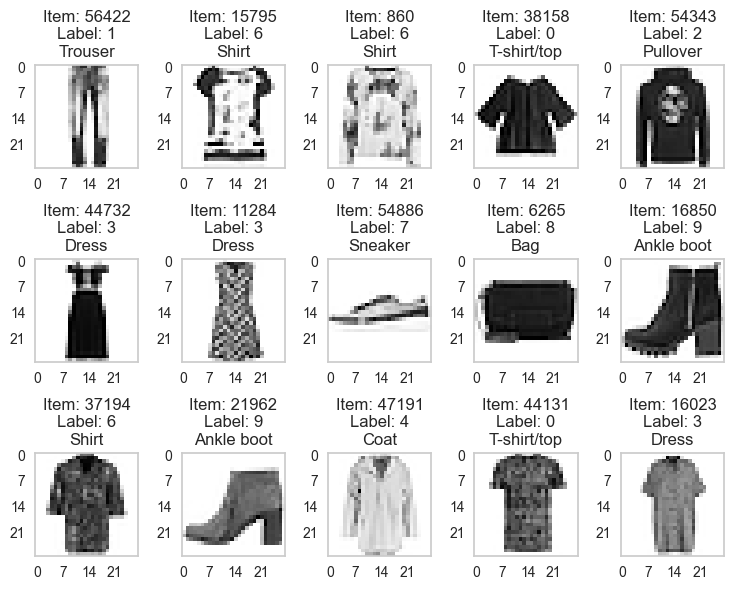

In [220]:
# First fix random seed so that everyone using this sees the same picture. Feel free to change it though!
random_seed=42

# specify the number of rows and columns you want to see
num_row = 3
num_col = 5

# Here we compute how many samples we want:
num = num_row*num_col 

# and here we use sklearns resample function to get us the samples.
images, labels, original_index=resample(X_train,
                                        Y_train,
                                        range(len(Y_train)),
                                        n_samples=num,
                                        random_state=random_seed) 

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    if num_row>1 and num_col>1:
        ax = axes[i//num_col, i%num_col]
    elif num >1:
        ax = axes[i]
    else: ax=axes
    #(image,ax,title,show_minor=False,show_major=False):
    custom_imshow(images[i],ax,f'Item: {original_index[i]}\nLabel: {labels[i]}\n{class_names_dict[labels[i]]}',show_minor=False,show_major=False)
    
plt.tight_layout()
plt.show()



Some of the items, e.g., Ankle boots and trousers look pretty different that should be fine. Others, e.g. shirts, pullovers and coats, however,look pretty similar. Let's see if our clustering algorithm will be able to separate them correctly.

Next, let's see how different items from each of the different classes look like: Is there something coming to your mind?

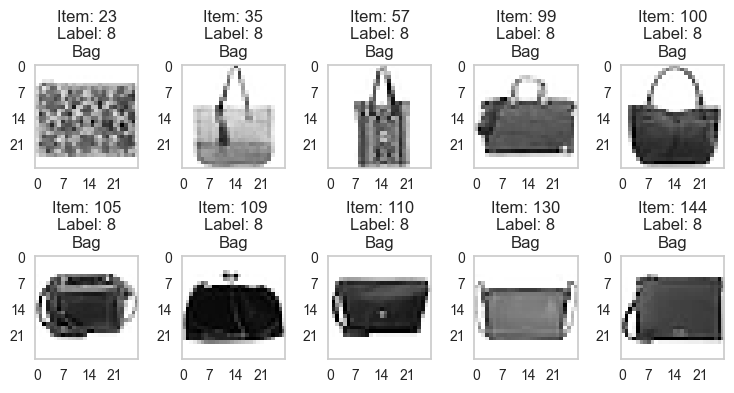

In [222]:
# Select which class to look at
class_number=8

# specify the number of rows and columns you want to see
num_row = 2
num_col = 5

# Here we compute how many samples we want:
num = num_row*num_col 

indices_for_class=np.argwhere(Y_train==class_number).flatten() #get all the indices that are samples of the class we are interested in
images = X_train[indices_for_class][:num] # filter for the indices and only get as many as we need
labels = Y_train[indices_for_class][:num]
original_index =indices_for_class[:num]   # keep original index, so that we can find the items again

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    if num_row>1 and num_col>1:
        ax = axes[i//num_col, i%num_col]
    elif num >1:
        ax = axes[i]
    else: ax=axes
    #(image,ax,title,show_minor=False,show_major=False):
    custom_imshow(images[i],ax,f'Item: {original_index[i]}\nLabel: {labels[i]}\n{class_names_dict[labels[i]]}',show_minor=False,show_major=False)
    
plt.tight_layout()
plt.show()

Some of the classes, e.g. the bags (label 8) contain items that look pretty dissimilar. On the other hand some classes look much more uniform, e.g. trousers (label 1).

## Pre-process Data for clustering

After getting a feeling for the data we are dealing with, we can start to bring the data into the correct format. Scikit-learn's `K-Means` implementation expects the data to be an array with the shape (n_samples, n_features). Currently our data has one dimension to much, so we will need to flatten the pixels for each picture changing the shape from 28 x 28 (width x height) to a flat vector of 784 pixels. 

In [3]:
# Current shape of data (number of sample, width, height)
print("Current shape X_train: ", X_train.shape)
print("Current shape X_test:  ", X_test.shape)

Current shape X_train:  (60000, 28, 28)
Current shape X_test:   (10000, 28, 28)


In [4]:
# Reshaping data using numpy
X_train_flat = X_train.reshape(60000, -1)
X_test_flat = X_test.reshape(10000, -1)

print("New shape X_train: ", X_train_flat.shape)
print("New shape X_test:  ", X_test_flat.shape)

New shape X_train:  (60000, 784)
New shape X_test:   (10000, 784)


Let's visualize what happened when we reshaped our data. The following plots compare the original 2-dimensional picture of one observation with the flattened array. You can think of it as cutting the picture horizontally in thin stripes and glueing them together to form a long stripe of pixels. 

> Note: To be able to see the color difference in the flattened image, we changed the aspect ratio. Ech pixel is not shown as a square but stretched vertically. If you want to display the original line of square pixels, you can change the parameter `aspect="auto"` to `aspect="equal"`. 

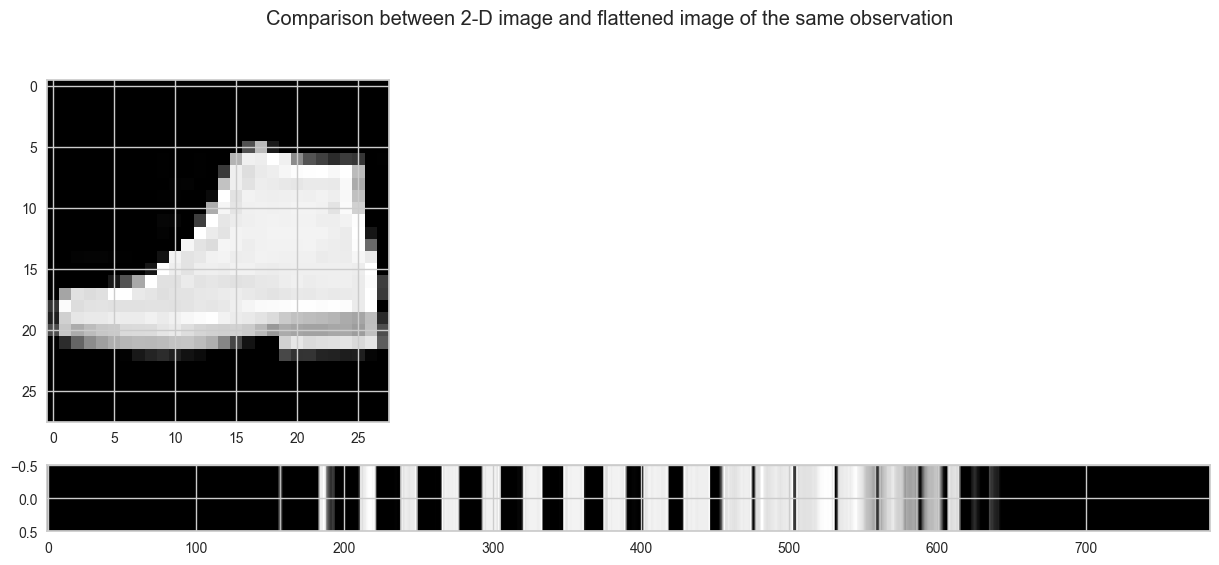

In [12]:
# If you want to see another observation change the value of the observation variable
observation = 42

fig, ax = plt.subplot_mosaic("A..;A..;A..;A..;BBB", figsize=(15, 6))
ax['A'].imshow(X_train[observation], cmap='gray', vmin=0, vmax=255)
ax['B'].imshow(X_train_flat[observation].reshape(-1,1).T, aspect='auto',  cmap='gray', vmin=0, vmax=255)
plt.suptitle("Comparison between 2-D image and flattened image of the same observation")
plt.subplots_adjust(hspace=0.5);

Now that our data has the correct shape, we can continue with the actual clustering process. Before we train our model, let's draw a random sample that consists of 6000 of the original 60000 pictures of the training set. 

In [6]:
# Draw random sample from training data using scikit-learn's resample function
X_sample_flat, y_sample = resample(X_train_flat, y_train, n_samples=6000, replace=False, stratify=y_train, random_state=1)

In [15]:
# Print shape of sample data
print("X_sample shape: ", X_sample_flat.shape)
print("y_sample shape: ", y_sample.shape)

X_sample shape:  (6000, 784)
y_sample shape:  (6000,)


In [18]:
# Print distribution of labels?
#pd.Series(y_sample).value_counts()

## Apply K-Means and Elbow Method

Finally we can cluster our data using K-Means. As you might remember, after initializing the cluster centroids K-Means alternates between two steps: 
1. assigning the data points to the nearest cluster centroid and 
2. updating the location of the centroids by calculating the mean of the data points assigned to each cluster 

until the assignment of the data points to the clusters doesn't change anymore. 

One major drawback of the algorithm is, that it cannot determine the amount of clusters itself. We need to define it when we fit the model. Sometimes the amount of clusters in our data set is given by the specific business case we are trying to solve (e.g. clustering customer data into a certain amount of groups), or we can gain some intuition during the EDA. But it can also happen, that we simply don't know what an appropriate amount of clusters would be. In those cases the elbow method can help us to select a value for k. 

In the next cell we will use the [yellowbrick](https://www.scikit-yb.org/en/latest/) package to create an elbow plot. 




> Note: It might seem counterintuitive that we use a method to determine the number of clusters in our data even if we already know that we have ten different categories. Keep in mind, that this is usually not the case! Clustering is a domain of **unsupervised learning**, where we have to deal with **unlabeled** data.

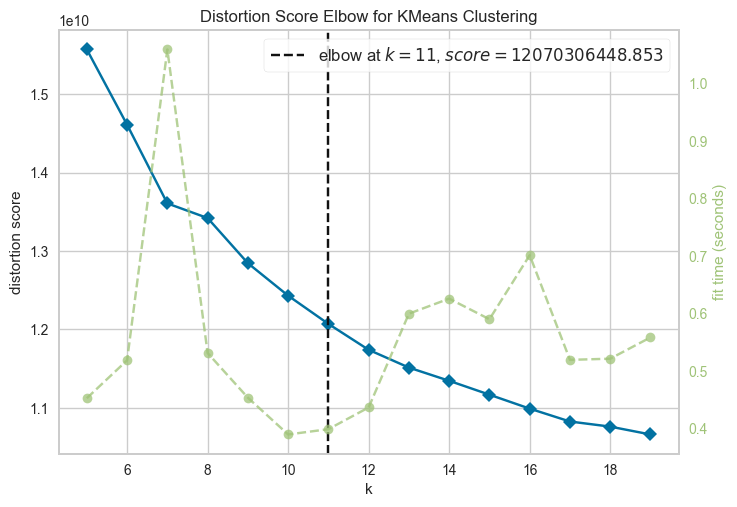

In [13]:
# Use elbow method with sample dataset to determine value for k 
kmeans_elbow_method = KMeans(init="k-means++", n_init="auto", random_state=1)
visualizer_elbow_method = KElbowVisualizer(kmeans_elbow_method, k=(5,20))

# Fit visualizer to sample data and display plot
visualizer_elbow_method.fit(X_sample_flat)   
visualizer_elbow_method.show();

Yellowbrick's elbow plot indicates with the dashed black line, that `k=11` is the best amount of clusters for our data. It is the point of maximum curvature of the blue curve showing the distortion score (aka. within-cluster sum of squares). Let's adopt the suggestion and fit `KMeans()` with 11 cluster. Besides the parameter for the amount of clusters `n_clusters` we can also define which initialisation method for placing the initial cluster centroids we want to use. We will use the default value `init=k-means++`, which assures that the centroids get placed as far away form each other as possible mitigating the risk of accidentally splitting a cluster in half. With the third parameter `n_init`, we can control how many times K-Means will be run with different starting position for the centroids. Using `auto` in combination with `k-means++` results in one run.

In [ ]:
# Train K-Means on whole training data
kmeans = KMeans(n_clusters=11 , init="k-means++", n_init="auto")
kmeans.fit(X_train_flat)

## Evaluate Performance and Error Analysis

In [ ]:
y_pred_train = kmeans.predict(X_train_flat)
y_pred_test = kmeans.predict(X_test_flat)

In [ ]:
print(rand_score(Y_train, y_pred_train))
print(rand_score(Y_test, y_pred_test))

In [ ]:
# pick a sample to plot
sample = 3
image = X_train[sample]

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
kmeans.inertia_

In [ ]:
centroid = kmeans.cluster_centers_[5].reshape(28,28)

In [ ]:
# specify the number of rows and columns you want to see
num_row = 3
num_col = 5

# get a segment of the dataset
num = num_row*num_col
images = kmeans.cluster_centers_
#labels = Y_train[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(kmeans.cluster_centers_[i].reshape(28,28), cmap='gray')

In [ ]:
y_pred = kmeans.predict(X_train.reshape(60000,-1))

In [ ]:
y_pred[20:40]

In [ ]:
plt.imshow(X_train[23], cmap="Greys");

In [ ]:
Y_train[23]

In [ ]:
num_row = 2
num_col = 5
class_label = 3

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i, pic in enumerate(np.where(y_pred == class_label)[0][:10]):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[pic].reshape(28,28), cmap='gray')

In [ ]:
plt.imshow(kmeans.cluster_centers_[class_label].reshape(28,28), cmap="Greys")

## DBSCAN

In [ ]:
model_s = KMeans(7, random_state=42)
visualizer_s = SilhouetteVisualizer(model_s, colors='yellowbrick')
visualizer_s.fit(X_train.reshape(60000,-1))        # Fit the data to the visualizer
visualizer_s.show()

In [ ]:
model_s = KMeans(10, random_state=42)
visualizer_s = SilhouetteVisualizer(model_s, colors='yellowbrick')
visualizer_s.fit(X_train.reshape(60000,-1))        # Fit the data to the visualizer
visualizer_s.show()

In [ ]:
dbscan = DBSCAN(eps=1200, min_samples=100)

dbscan.fit(X_train.reshape(60000, -1))

In [ ]:
sum(dbscan.labels_)

In [ ]:
pd.Series(dbscan.labels_).value_counts()

In [ ]:
# Initialize and fit NearestNeighbors object
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fitted = neighbors.fit(X_train.reshape(60000, -1))

# Get distance and indices of pairs of points
distances, indices = neighbors_fitted.kneighbors(X_train.reshape(60000, -1))

# Sort distances 
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot distances to determine suitable value for epsilon
plt.plot(distances)
plt.hlines(0.025, 0, 2130, linestyles='--', color='black',linewidth=2)
plt.ylabel("Distance", size=22)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title("Find suitable value for epsilon", size=26)
plt.text(1900, 0.03,"~ 0.025", size=22);

In [ ]:
plt.plot(distances)
#plt.hlines(0.025, 0, 2130, linestyles='--', color='black',linewidth=2)
plt.ylabel("Distance", size=22)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title("Find suitable value for epsilon", size=26)
plt.text(1900, 0.03,"~ 0.025", size=22);